<center>
    <h1>Fruit Inspection</h1>
    <h2>Image Processing and Computer Vision</h2>
    <h3>Facundo Nicolas Maidana and Riccardo Spolaor</h3>
    <h4>facundo.maidana@studio.unibo.it; riccardo.spolaor@studio.unibo.it</h4>
</center>

---

This notebook presents the development of a system aimed at locating defects and imperfection in fruits. Each fruit is acquired through a NIR *(Near Infra-Red)* and color camera that present little parallax effect among each other.

<table>
    <tr>
        <td><img src="images/first task/C0_000001.png" width="200"/></td>
        <td><img src="images/first task/C1_000001.png" width="200"/></td>
    </tr>
    <tr>
        <td style='text-align:left'>NIR example</td>
        <td style='text-align:left'>Color example</td>
    </tr>
</table>

# 00 Prerequisites
The libraries necessary for the task are imported.

In [1]:
%matplotlib inline

import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
from time import process_time, time

# Utils libraries
from graphics import *
from utils import *

The cell below illustrates the version of `OpenCV` used for the task.

In [2]:
print(f'Using OpenCV version: {cv2.__version__}.')

Using OpenCV version: 4.6.0.


The random seed is set for both the `numpy` and `OpenCV` libraries in order to guarantee reproducibility of results.

In [3]:
SEED = 42

cv2.setRNGSeed(SEED)
np.random.seed(SEED)

# 01 First task: Fruit Segmentation and Defect Detection
The first task considers the images in the folder `images/first task/`, that present apples with external defects which are clearly visible.

In order to localize these defects two steps have to be carried out:
- Each fruit should be outlined by means of a binary mask that separates the foreground (the fruit) from the background. This step is performed through a tresholding technique;
- A search to identify the defects on the fruit must be carried out on the outlined portion of the image.

*Note: given the fact that NIR and color images have little parallax, a mask can be computed on one and applied to the other.*

## 01.1 Image analysis 
The series of images is firstly imported and plotted.

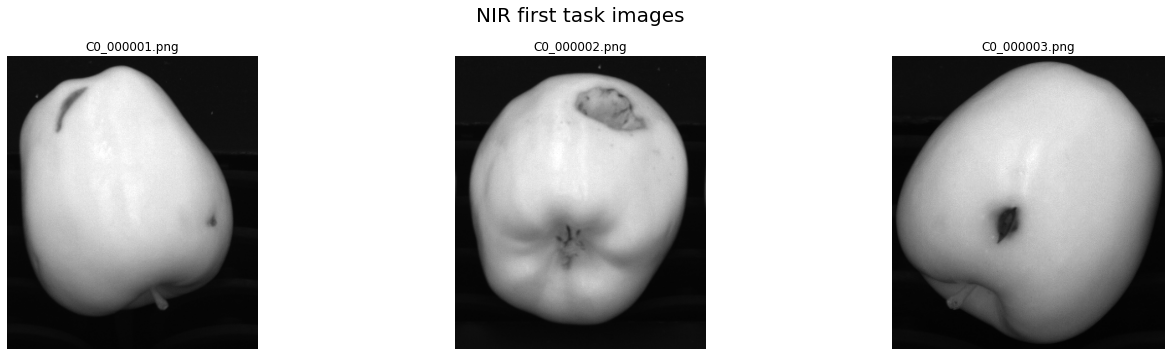

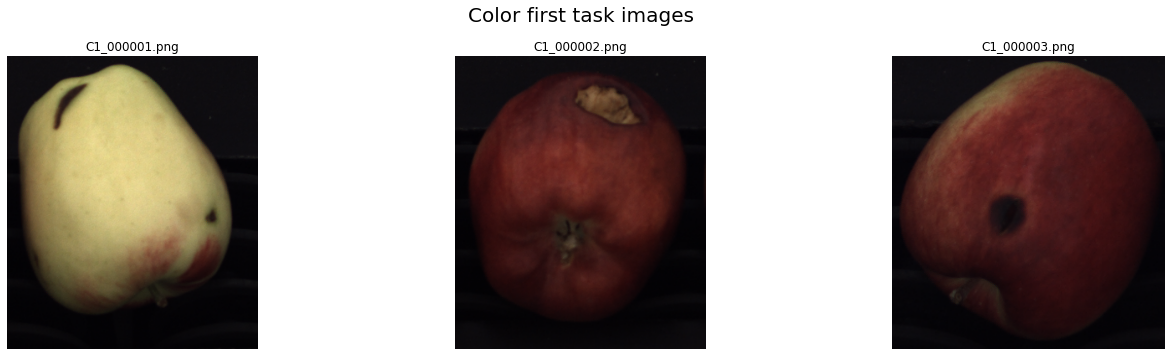

In [4]:
# Create two arrays containing the names of the NIR and color images respectively
nir_names, color_names = [[f'C{j}_00000{i}.png' for i in range(1,4)] for j in [0,1]]

# Directory where the images are saved
DIR = 'images/first task/'

# Import NIR and color images
nir_imgs = [cv2.imread(f'{DIR}{img}', cv2.IMREAD_GRAYSCALE) for img in nir_names]
color_imgs = [cv2.imread(f'{DIR}{img}') for img in color_names]

# Plot the NIR and color images
plot_image_grid(nir_imgs, 'NIR first task images', nir_names)
plot_image_grid(color_imgs, 'Color first task images', color_names)

Next, the *gray-level histograms* of the three NIR images are computed and shown.

By observing the results we can identify a greater concentration of pixels around the interval $[0, 25]$, which should correspond to background pixels. Moreover, other small peaks are present around higher values for the gray levels, which should represent foreground pixels belonging to the fruit. 

Unfortunately, the distribution of background and foreground pixels is slightly different among the three images. Furthermore the istograms are not clearly *bimodal* and an actual treshold that binarizes the image cannot be trivially identified. It can be observed that image `C0_000003.png` presents an even more confusing separation among background and foreground pixels.

These outcomes should be expected since the NIR images shown above are not *inherently binary*. The shadowy areas due to the lighting variations and the presence of the defects and textures on the fruit are the main reasons of the lack of bimodality in the histogram.

Furthermore, sources of noise may be another impacting factor, in fact, some of the tresholding algorithms presented in the next section consider image preprocessing.

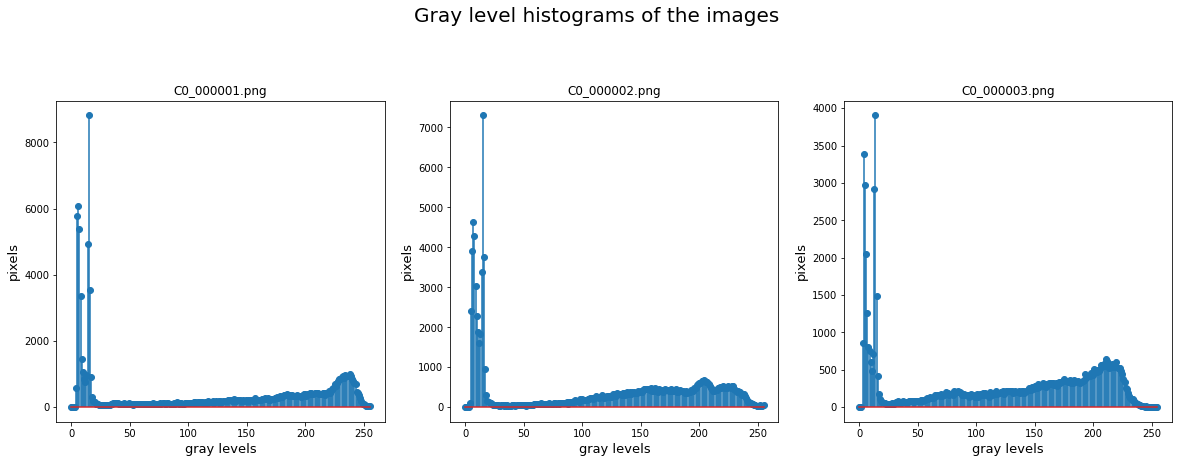

In [5]:
plot_histogram_grid(nir_imgs, 'Gray level histograms of the images', nir_names)

## 01.2 Outline the fruit by generating a binary mask
In order to compute the binary mask that outlines the fruit image segmentation through binary tresholding is applied.

In particular, four different methods are taken into consideration and compared in terms of time performances and quality of the output. Different preprocessing approaches are considered to guarantee accurate results are obtained.

The considered techniques are:
- *Binarization by Intensity Thresholding*;
- *Otsu's Algorithm*;
- *Triangle Algorithm*;
- *Adaptive Thresholding*.

### 01.2.1 Preprocessing noise
In order to guarantee better performances during the binarization tasks a pre-processing operation has been applied to the images to remove unwanted noisy signals.

More specifically, a combination of a *Median blur* filter followed by a *Gaussian Blur* one seemed to be the best combination to obtain better segmentation results. Median filters impulse signal elimination is effective when followed by other liner filters in order to remove gaussian noise.

The following pipeline is though followed for preprocessing:
- A Median Blur filter using a $(3 \times 3)$ kernel is applied to the image to remove possible impulse signal;
- A Gaussian Blur filter is applied to the image to remove unwanted Gaussian Noise and to blur the image. The filter used a $\sigma$ value of $2$ and a kernel of dimension $(2 \cdot k + 1, 2 \cdot k + 1)$, where $k$ is computed through a *rule-of-thumb* as $k = \left \lceil 3 \cdot \sigma \right \rceil$.

The time to compute these operations is $\approx 0.002$ seconds for the three images.

## TODO

Explain that we use Median Filter because:

- its fast
- edge preserving
- impulse noise like artifact in background seem to be removed in both filters
- median is more effective in a smooth mask binarization (osservazione che facciamo noi)


In [6]:
%%time
SIGMA = 2
K = math.ceil(3*SIGMA)

median_filtered_images = [cv2.medianBlur(img,5) for img in nir_imgs]
filtered_images = median_filtered_images #[cv2.GaussianBlur(img, (2*K+1, 2*K+1), SIGMA) for img in median_filtered_images]

Wall time: 1.96 ms


In [7]:
"""%%time
SIGMA = 2
K = math.ceil(3*SIGMA)

median_filtered_images = [cv2.bilateralFilter(img,11, 100, 75) for img in nir_imgs]
filtered_images = median_filtered_images #[cv2.GaussianBlur(img, (2*K+1, 2*K+1), SIGMA) for img in median_filtered_images]""";

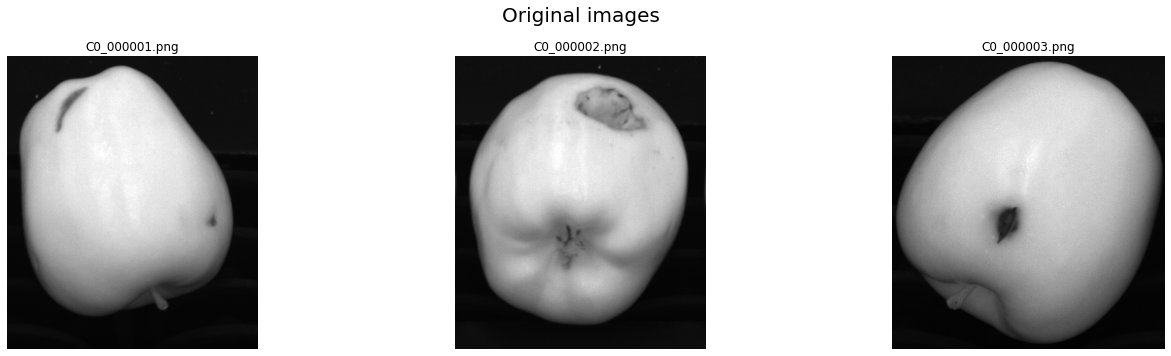

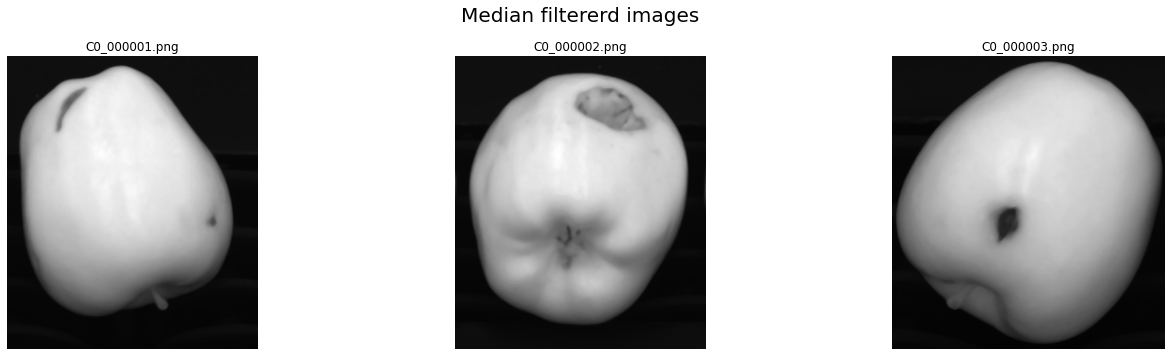

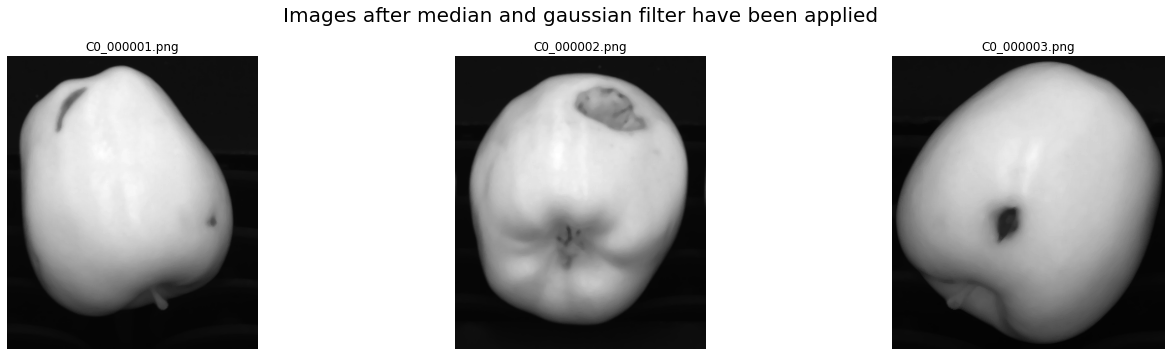

In [8]:
# Plot the NIR and color images
plot_image_grid(nir_imgs, 'Original images', nir_names)
plot_image_grid(median_filtered_images, 'Median filtererd images', nir_names)
plot_image_grid(filtered_images, 'Images after median and gaussian filter have been applied', nir_names)

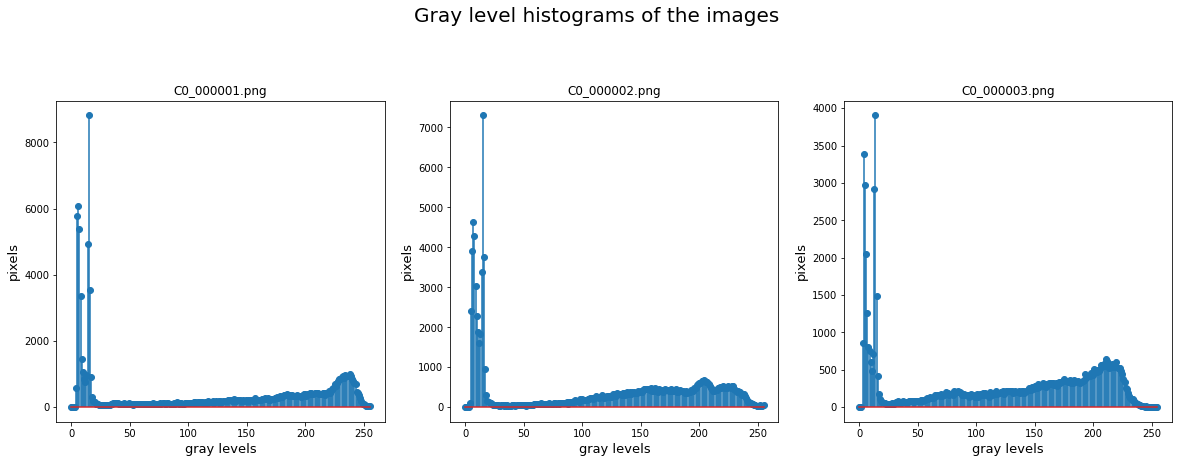

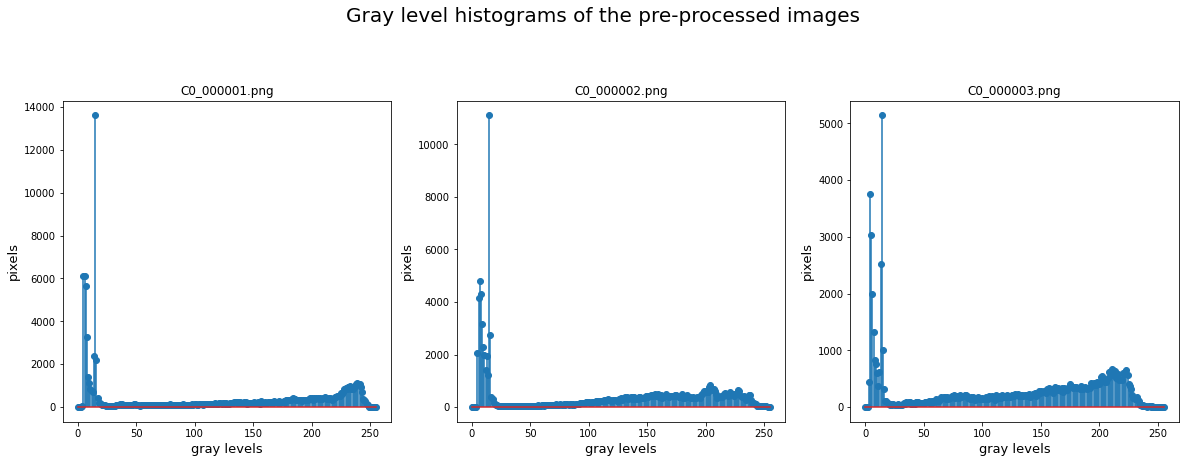

In [9]:
plot_histogram_grid(nir_imgs, 'Gray level histograms of the images', nir_names)
plot_histogram_grid(filtered_images, 'Gray level histograms of the pre-processed images', nir_names)

### 01.2.2 Binarization by Intensity Tresholding
This first approach is the simplest and faster. A global treshold $t$ is manually provided in order to binarize the image $I$ by transforming each of its pixels $(i,j)$, such that:

$$\forall i,j, \ I(i,j) = 
\begin{cases} 
    0, & \text{if} \ I(i,j) \leq t \\
    255, & \text{otherwise}
\end{cases}$$

Where $0$ corresponds to background pixels and $255$ to foreground pixels.

As previously explained, finding such treshold is not trivial given that the gray-level histogram is not bimodal.
Various experiments have shown that a good value of this treshold that guarantees a good binarization is found in the range $[20-30]$ after a *Gaussian smoothing* filter has been applied to remove noisy signals.

The gaussian filter has

The used filter 

0.0


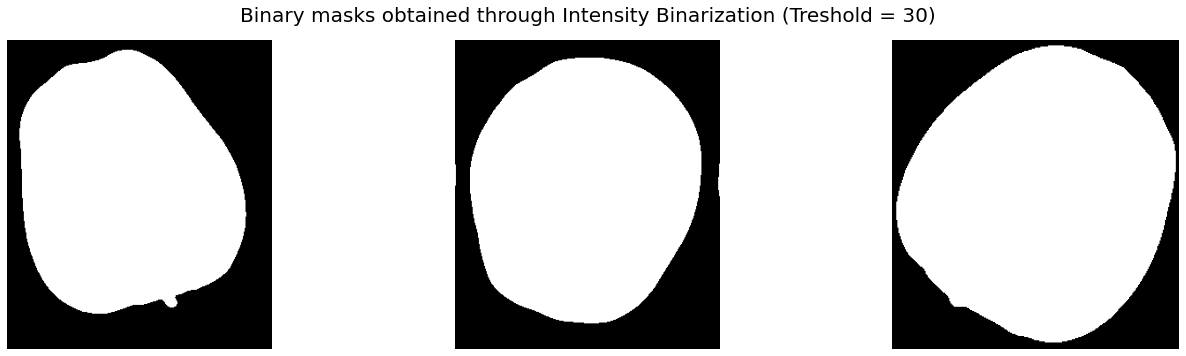

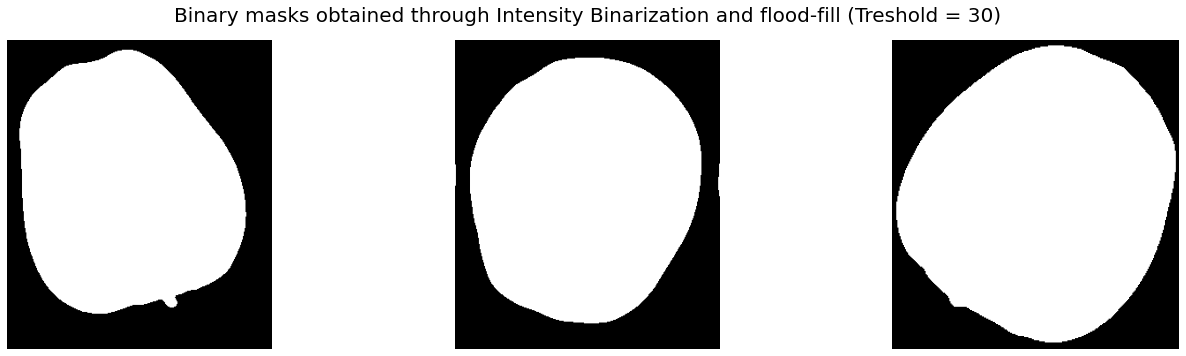

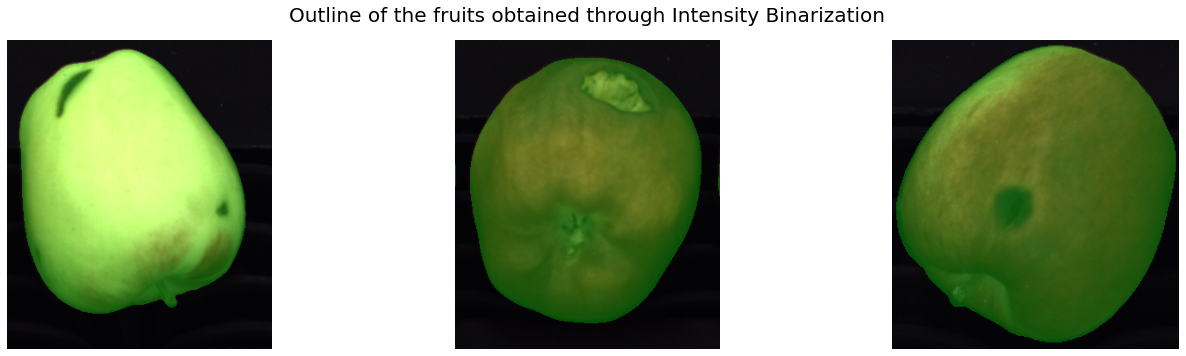

In [10]:
# Set the treshold for image segmentation
MANUAL_TRESHOLD = 30

masks = []

# Set
SIGMA = 2
K = math.ceil(3*SIGMA)

s = process_time()

for img in filtered_images:
    #blur = cv2.medianBlur(img, 3)
    #blur = cv2.GaussianBlur(blur, (2*K+1, 2*K+1), SIGMA)
    treshold, mask = cv2.threshold(img, MANUAL_TRESHOLD, 255, cv2.THRESH_BINARY)
    masks.append(mask)

print(process_time() - s)

plot_image_grid(masks, f'Binary masks obtained through Intensity Binarization (Treshold = {MANUAL_TRESHOLD})')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, f'Binary masks obtained through Intensity Binarization and flood-fill (Treshold = {MANUAL_TRESHOLD})')

bounded_images = []

for idx, img in enumerate(color_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Intensity Binarization')

In [11]:
# Time on 3,000 instances
s = process_time()

for img in [im for im in filtered_images for i in range(1_000)]:
    #blur = cv2.medianBlur(img, 3)
    #blur = cv2.GaussianBlur(blur, (2*K+1, 2*K+1), SIGMA)
    _, _ = cv2.threshold(img, MANUAL_TRESHOLD, 255, cv2.THRESH_BINARY)
    #masks.append(mask)

print(process_time() - s)


0.15625


In [12]:
'''# TODO Parametrize
# this is just for visualization.
# By looking at the greyscale histogram it is evident that the image is not inherently binary 
# and a clear threshold dividing background and foreground + imperfercions can't be found manually.
MANUAL_TRESHOLD = 25
s = time()
masks = [cv2.threshold(i, MANUAL_TRESHOLD, 255, cv2.THRESH_BINARY)[1] for i in nir_imgs]
print(time() - s)
plot_image_grid(masks, f'Binary masks obtained through Intensity Binarization (Treshold = {MANUAL_TRESHOLD})')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, f'Binary masks obtained through Intensity Binarization and flood-fill (Treshold = {MANUAL_TRESHOLD})')

bounded_images = []

for idx, img in enumerate(color_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Intensity Binarization')''';

0.015625


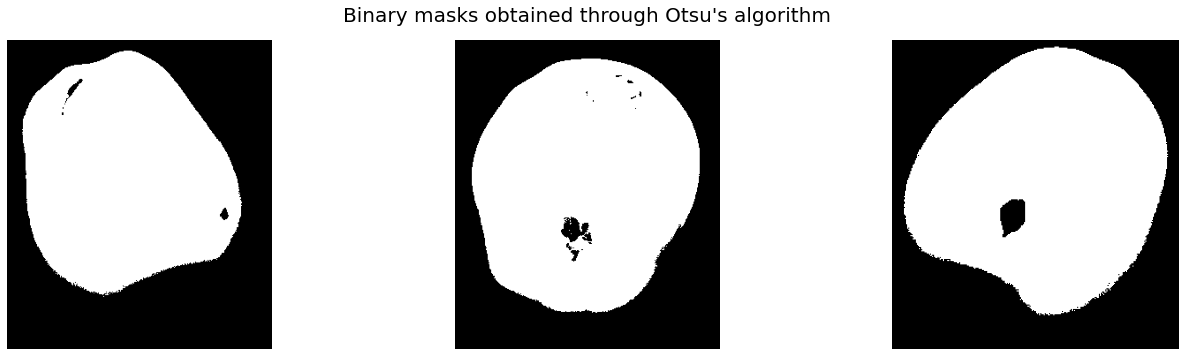

Tresholds obtained for each image: [109.0, 98.0, 104.0]


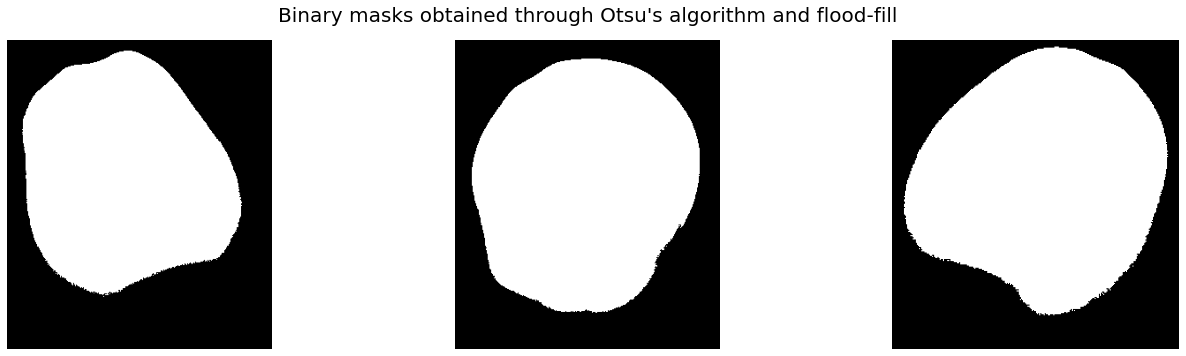

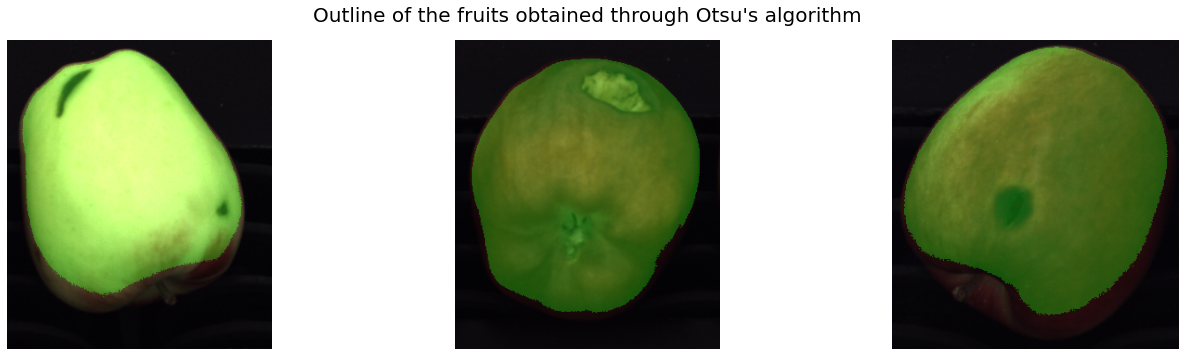

In [13]:
s = process_time()
masks = []
tresholds = []

#s = time()

for img in nir_imgs:
    treshold, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    masks.append(mask)
    tresholds.append(treshold)

print(process_time() - s)

plot_image_grid(masks, f'Binary masks obtained through Otsu\'s algorithm')

print(f'Tresholds obtained for each image: {tresholds}')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 'Binary masks obtained through Otsu\'s algorithm and flood-fill')

bounded_images = []

for idx, img in enumerate(color_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    

plot_image_grid(bounded_images, 'Outline of the fruits obtained through Otsu\'s algorithm')

0.0


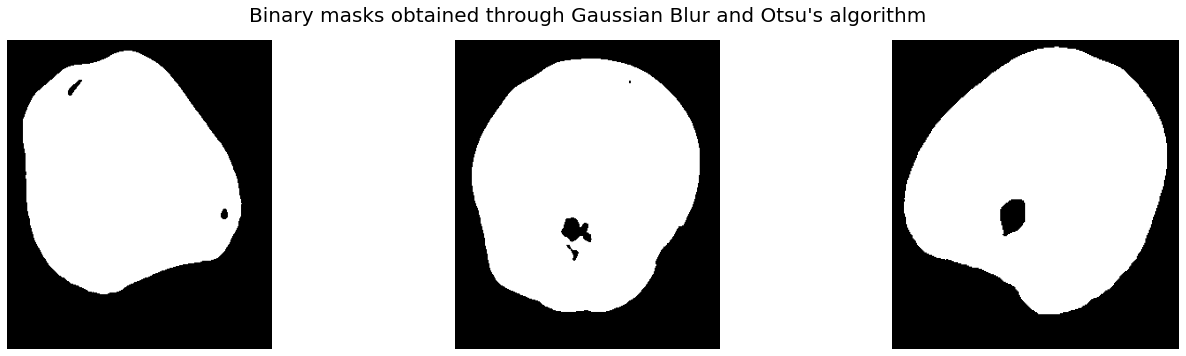

Tresholds obtained for each image: [109.0, 98.0, 104.0]


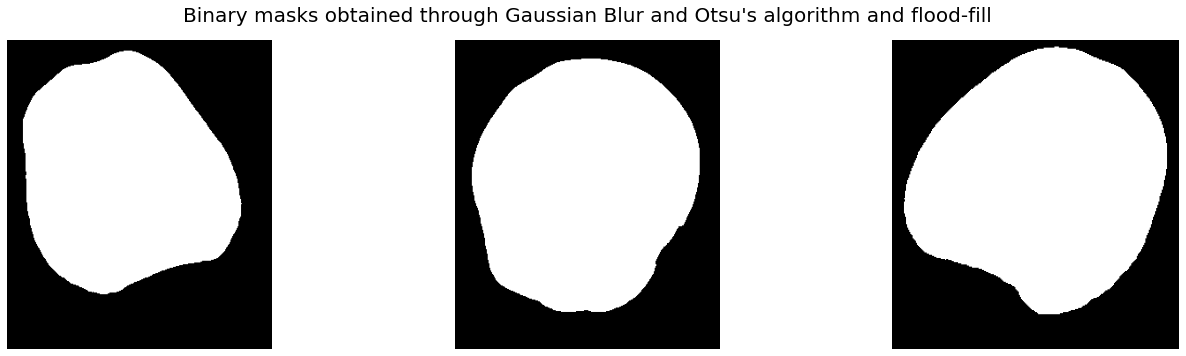

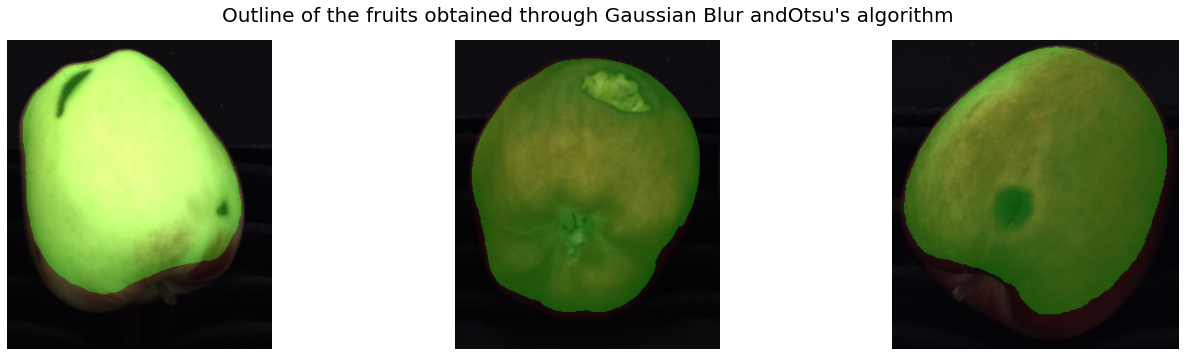

In [14]:
masks = []
tresholds = []
s = process_time()
for img in filtered_images:
    sigma=2
    k = math.ceil(3*sigma)
    #blur = cv2.medianBlur(img, 3)
    #blur = cv2.GaussianBlur(blur, (2*k+1, 2*k+1), sigma)
    #blur = cv2.medianBlur(img, 15)
    treshold, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    masks.append(mask)
    tresholds.append(treshold)
print(process_time() - s)

plot_image_grid(masks, f'Binary masks obtained through Gaussian Blur and Otsu\'s algorithm')

print(f'Tresholds obtained for each image: {tresholds}')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 'Binary masks obtained through Gaussian Blur and Otsu\'s algorithm and flood-fill')

bounded_images = []

for idx, img in enumerate(color_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Gaussian Blur andOtsu\'s algorithm')

In [15]:
def kittler(im):
    """
    The reimplementation of Kittler-Illingworth Thresholding algorithm by Bob Pepin
    Works on 8-bit images only
    Original Matlab code: https://www.mathworks.com/matlabcentral/fileexchange/45685-kittler-illingworth-thresholding
    Paper: Kittler, J. & Illingworth, J. Minimum error thresholding. Pattern Recognit. 19, 41–47 (1986).
    """
    out = np.zeros_like(im)
    h,g = np.histogram(im.ravel(),256,[0,256])
    h = h.astype(np.float)
    g = g.astype(np.float)
    g = g[:-1]
    c = np.cumsum(h)
    m = np.cumsum(h * g)
    s = np.cumsum(h * g**2)
    sigma_f = np.sqrt(s/c - (m/c)**2)
    cb = c[-1] - c
    mb = m[-1] - m
    sb = s[-1] - s
    sigma_b = np.sqrt(sb/cb - (mb/cb)**2)
    p =  c / c[-1]
    v = p * np.log(sigma_f) + (1-p)*np.log(sigma_b) - p*np.log(p) - (1-p)*np.log(1-p)
    v[~np.isfinite(v)] = np.inf
    idx = np.argmin(v)
    t = g[idx]
    out[im >= t] = 255
    return t, out

0.03125


<ipython-input-15-b17d9b0817bc>:16: RuntimeWarning: invalid value encountered in true_divide
  sigma_f = np.sqrt(s/c - (m/c)**2)
<ipython-input-15-b17d9b0817bc>:20: RuntimeWarning: invalid value encountered in true_divide
  sigma_b = np.sqrt(sb/cb - (mb/cb)**2)
<ipython-input-15-b17d9b0817bc>:22: RuntimeWarning: divide by zero encountered in log
  v = p * np.log(sigma_f) + (1-p)*np.log(sigma_b) - p*np.log(p) - (1-p)*np.log(1-p)
<ipython-input-15-b17d9b0817bc>:22: RuntimeWarning: invalid value encountered in multiply
  v = p * np.log(sigma_f) + (1-p)*np.log(sigma_b) - p*np.log(p) - (1-p)*np.log(1-p)


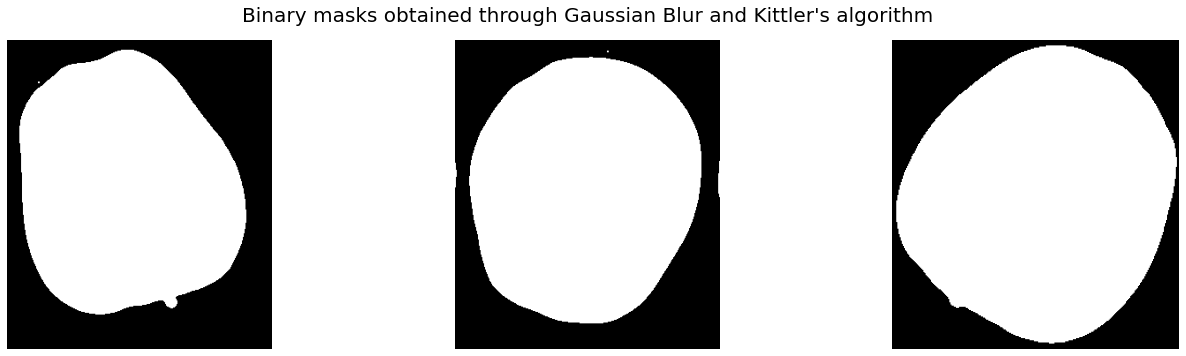

Tresholds obtained for each image: [25.0, 25.0, 23.0]


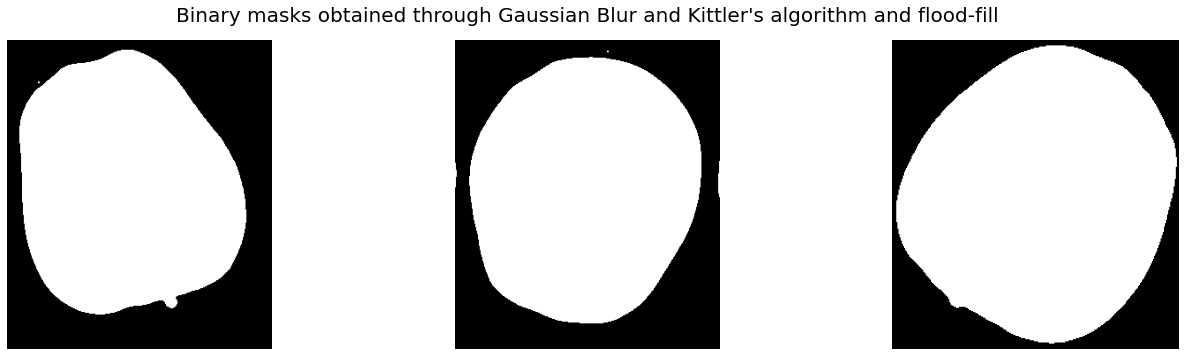

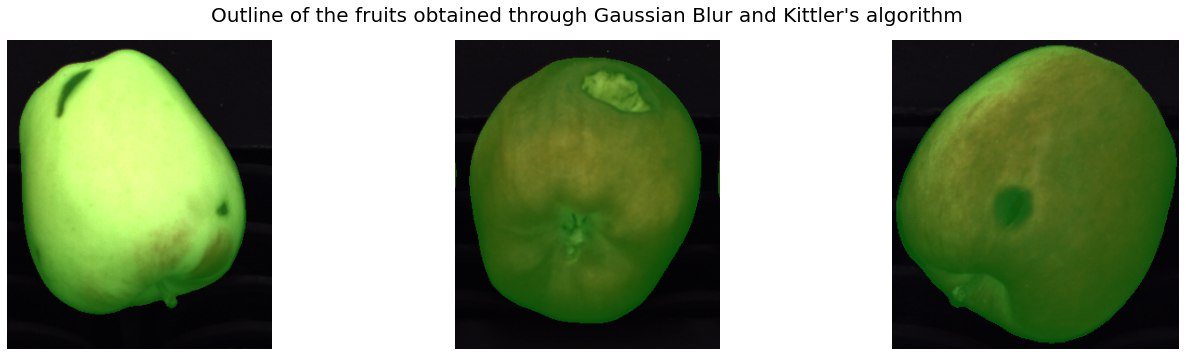

In [16]:
masks = []
tresholds = []

s = process_time()
for img in filtered_images:
    #sigma=2
    #k = math.ceil(3*sigma)
    #blur = cv2.medianBlur(img, 3)
    #blur = cv2.GaussianBlur(blur, (2*k+1, 2*k+1), sigma)
    #blur = cv2.medianBlur(img, 15)
    treshold, mask = kittler(img)
    masks.append(mask)
    tresholds.append(treshold)
print(process_time() - s)
    
plot_image_grid(masks, f'Binary masks obtained through Gaussian Blur and Kittler\'s algorithm')

print(f'Tresholds obtained for each image: {tresholds}')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 'Binary masks obtained through Gaussian Blur and Kittler\'s algorithm and flood-fill')

bounded_images = []

for idx, img in enumerate(color_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Gaussian Blur and Kittler\'s algorithm')

In [17]:
'''masks = []
tresholds = []

s = time()
for img in nir_imgs:
    sigma = 2
    k = math.ceil(3*sigma)
    blur = cv2.medianBlur(img, 11)
    blur = cv2.GaussianBlur(blur, (2*k+1, 2*k+1), sigma)
    #blur = cv2.bilateralFilter(blur, d = 7, sigmaColor = 10, sigmaSpace = 3)
    treshold, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)
    masks.append(mask)
    tresholds.append(treshold)
print(time() - s)
    
plot_image_grid(masks, f'Binary masks obtained through the triangle algorithm')

print(f'Tresholds obtained for each image: {tresholds}')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 'Binary masks obtained through the triangle algorithm and flood-fill')

bounded_images = []

for idx, img in enumerate(color_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through the triangle algorithm')''';

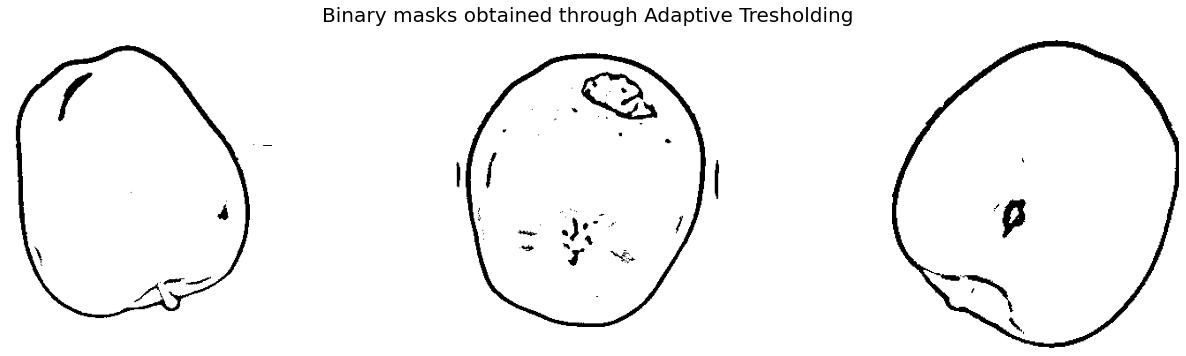

0.171875


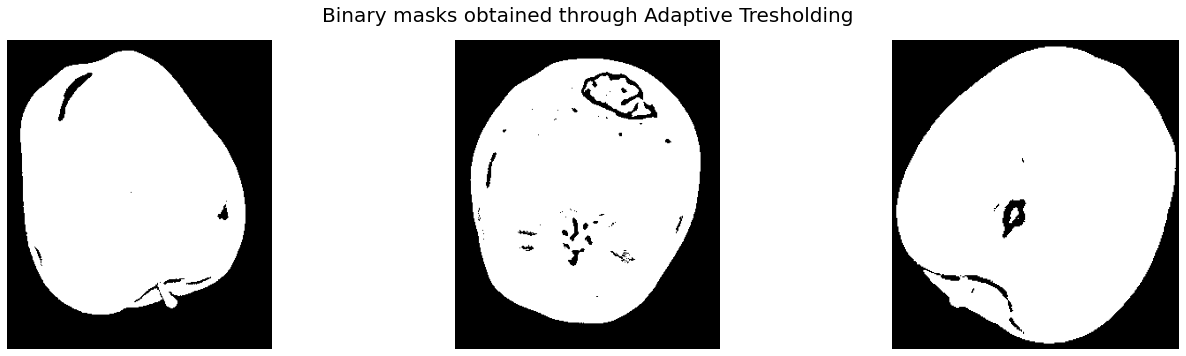

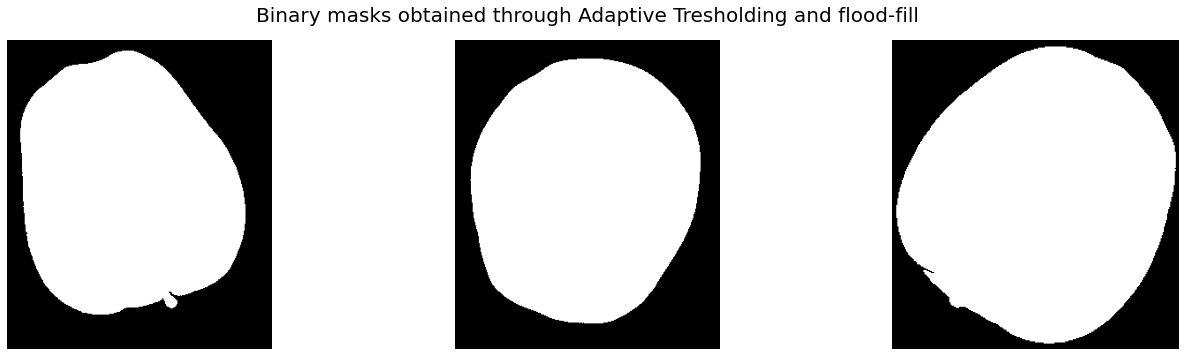

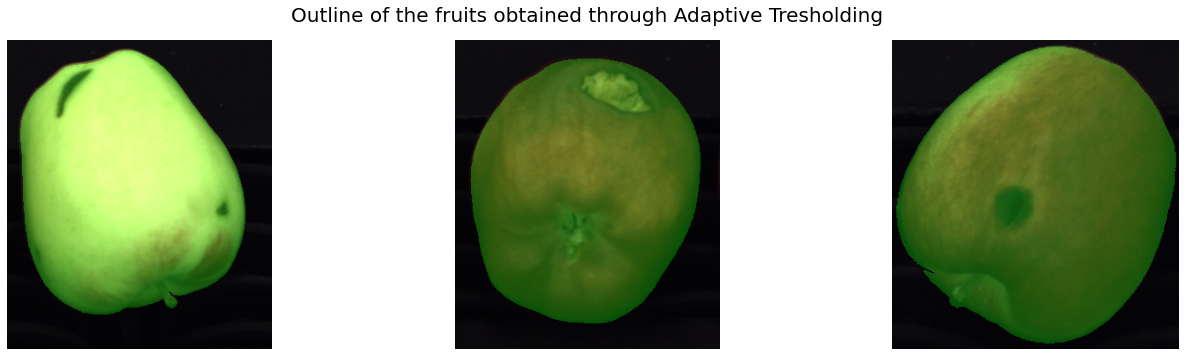

In [22]:
masks = []

s = process_time()
for img in filtered_images:
    #sigma = 2
    #k = math.ceil(3*sigma)
    #blur = cv2.medianBlur(img, 3)
    #blur = cv2.GaussianBlur(blur, (2*k+1, 2*k+1), sigma)
    #img_blur = cv2.medianBlur(img, 5)
    
    # We applied ADAPTIVE_THRESH_MEAN_C because its a faster operator (rather than Gaussian)
    mask = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 5)
    masks.append(mask)

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding')
    

# Pad masks and flood-fill the background
masks = [np.pad(m, 1, mode='constant', constant_values=255) for m in masks]
for m in masks:
    cv2.floodFill(m, None, (0,0), 0)
# Downsample the masks to their original size
masks = [m[1:-1,1:-1] for m in masks]
print(process_time() - s)

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding and flood-fill')

bounded_images = []

for idx, img in enumerate(color_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Adaptive Tresholding')

In [23]:
# Time on 1,000 instances
s = process_time()

for img in [im for im in filtered_images for i in range(1_000)]:
    #blur = cv2.medianBlur(img, 3)
    #blur = cv2.GaussianBlur(blur, (2*K+1, 2*K+1), SIGMA)
    _, m = cv2.threshold(img, MANUAL_TRESHOLD, 255, cv2.THRESH_BINARY)
    # Pad masks and flood-fill the background
    np.pad(m, 1, mode='constant', constant_values=255)
    cv2.floodFill(m, None, (0,0), 0)
    # Downsample the masks to their original size
    m = m[1:-1,1:-1]

print(process_time() - s)

1.59375


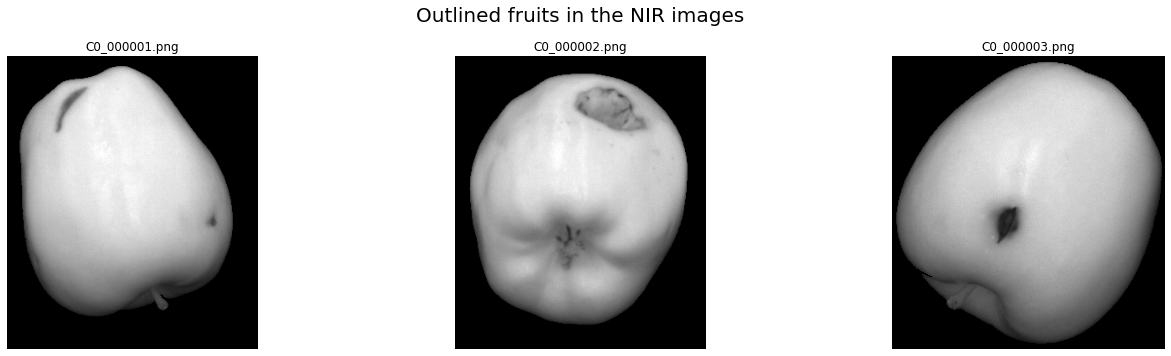

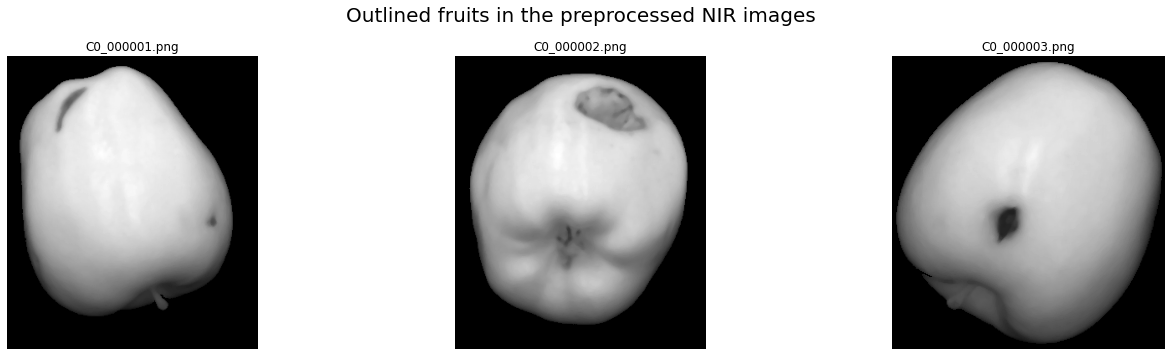

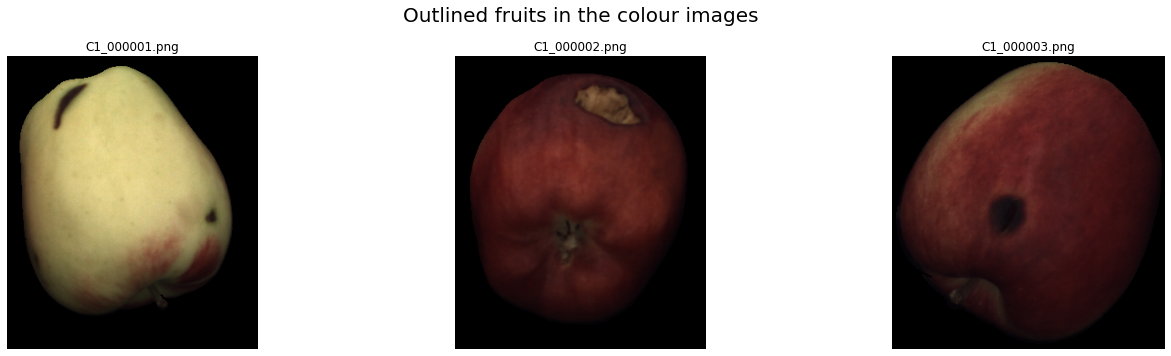

In [24]:
masked_nir_imgs = [nir_imgs[i] & masks[i] for i in range(len(masks))]
masked_filtered_imgs = [filtered_images[i] & masks[i] for i in range(len(masks))]
masked_colour_imgs = [color_imgs[i] &  cv2.cvtColor(masks[i], cv2.COLOR_GRAY2BGR) for i in range(len(masks))]

plot_image_grid(masked_nir_imgs, 'Outlined fruits in the NIR images', nir_names)
plot_image_grid(masked_filtered_imgs, 'Outlined fruits in the preprocessed NIR images', nir_names)
plot_image_grid(masked_colour_imgs, 'Outlined fruits in the colour images', color_names)

## 01.3 Defects identification

HINT: the defects have strong edges, so edge extraction algorithm should help. Also, they usually exhibit a far
darker color with respect to the neighboring areas of the fruit


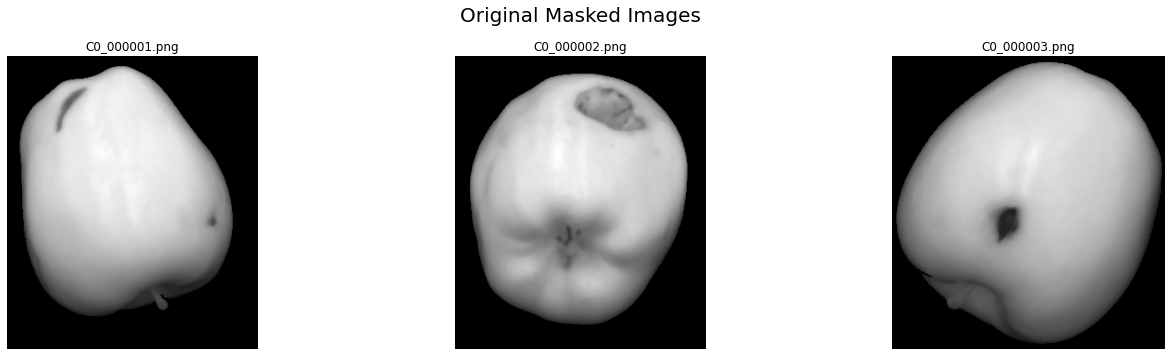

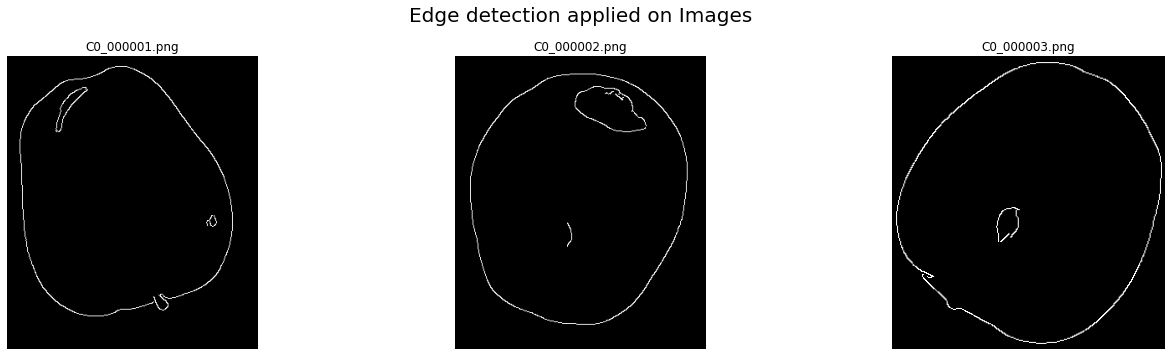

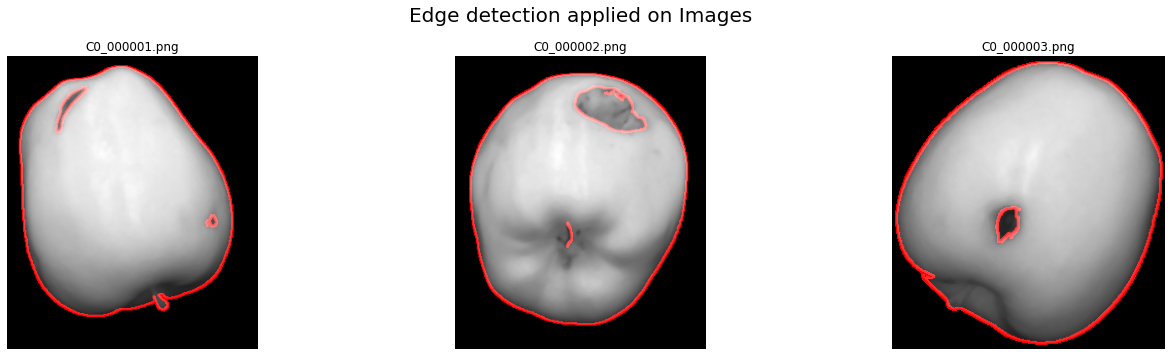

In [135]:
sigma = 1
k = math.ceil(3*sigma)

x = 60
y = 130

blur_masked_filtered_imgs = [cv2.GaussianBlur(img, (2*k+1, 2*k+1), sigma) for img in masked_filtered_imgs]

edges_imgs = [cv2.Canny(img, x, y) for img in blur_masked_filtered_imgs]

imgs_with_edge = []

for idx, img in enumerate(masked_filtered_imgs):
    red_edge_mask = cv2.cvtColor(edges_imgs[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    red_edge_mask[:,:,:-1] = 0
    
    element = cv2.getStructuringElement(0, (3, 3))
    imgs_with_edge.append(cv2.addWeighted(cv2.dilate(red_edge_mask, element), 1,  cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), 1, 0))

plot_image_grid(masked_filtered_imgs, 'Original Masked Images', nir_names)
plot_image_grid(edges_imgs, 'Edge detection applied on Images', nir_names)
plot_image_grid(imgs_with_edge, 'Edge detection applied on Images', nir_names)

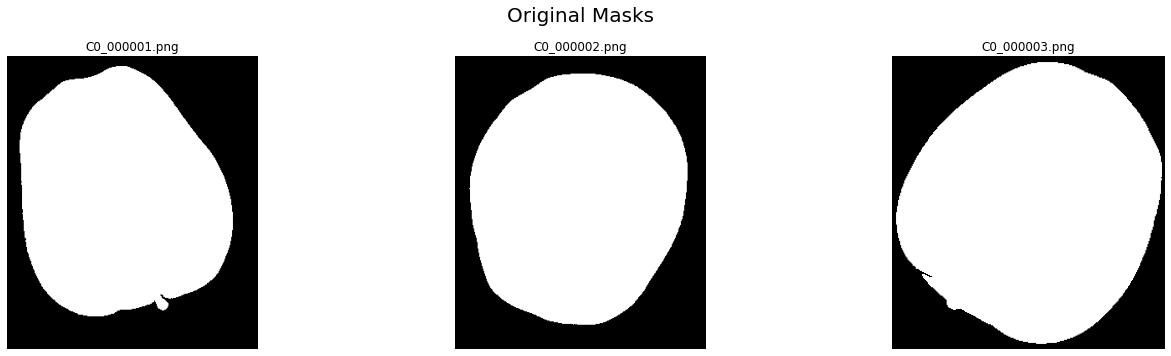

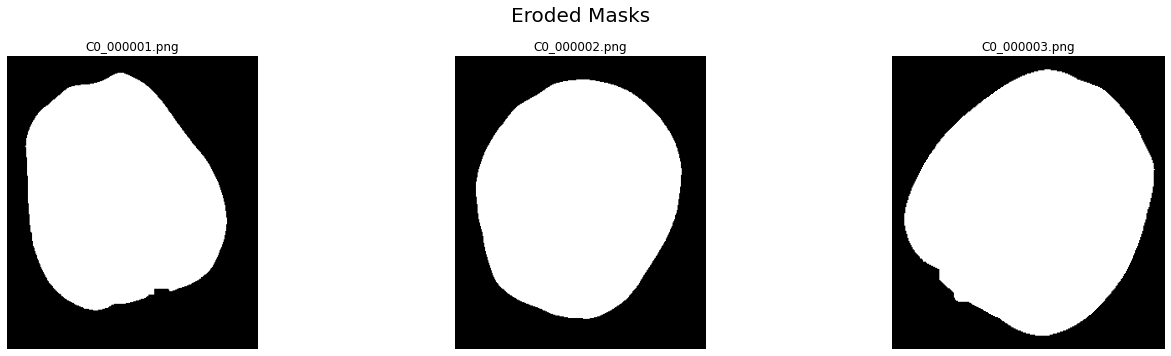

In [136]:
element = cv2.getStructuringElement(0, (15, 15))
eroded_masks = [cv2.erode(img, element) for img in masks]

plot_image_grid(masks, 'Original Masks', nir_names)
plot_image_grid(eroded_masks, 'Eroded Masks', nir_names)

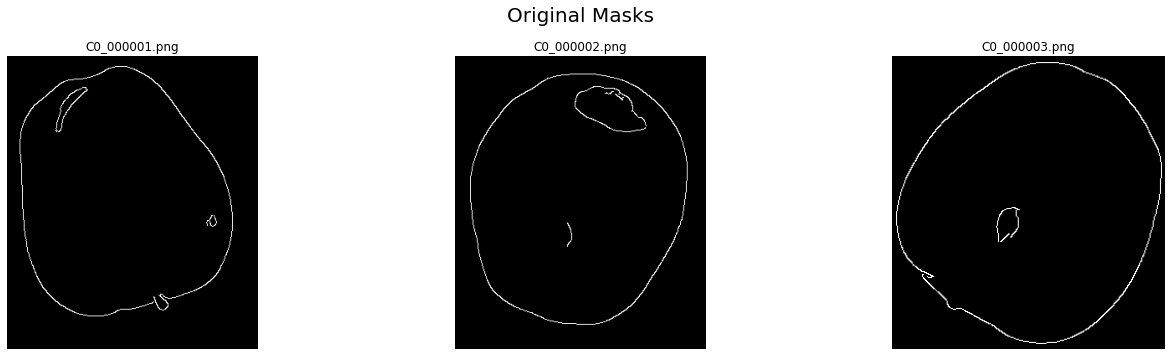

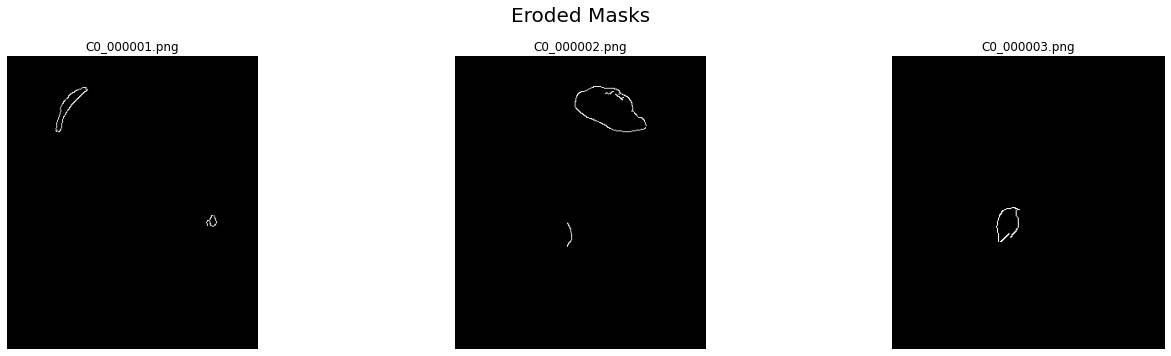

In [137]:
eroded_edge_masks = [edges_imgs[i] &  eroded_masks[i] for i in range(len(masks))]

plot_image_grid(edges_imgs, 'Original Masks', nir_names)
plot_image_grid(eroded_edge_masks, 'Eroded Masks', nir_names)

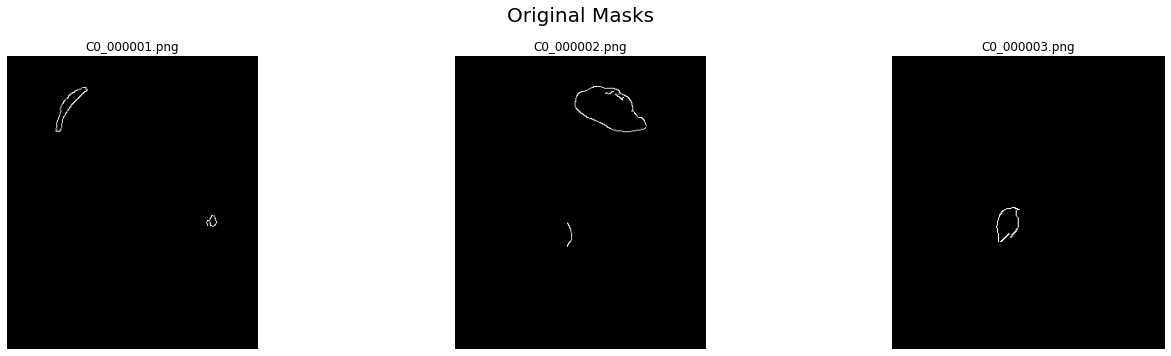

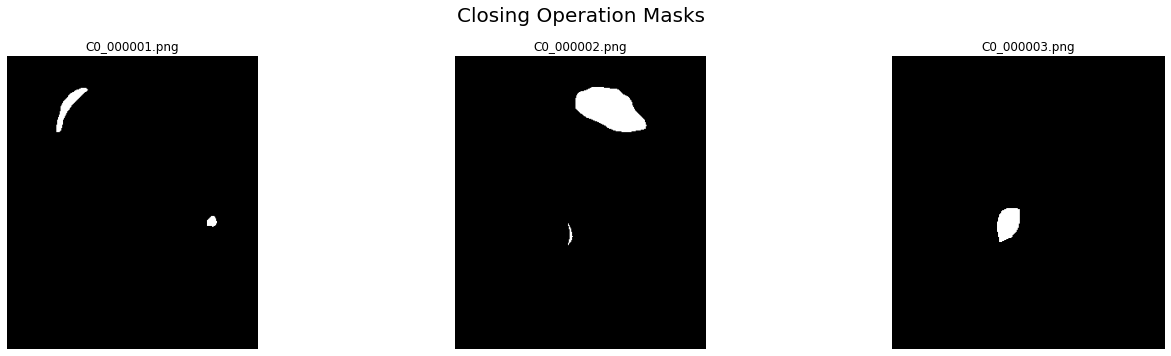

In [144]:
# todo cv2 parameter to express structuring element to enhance code readability
element = cv2.getStructuringElement(2, (50, 50))

plot_image_grid(eroded_edge_masks, 'Original Masks', nir_names)
closing_edges = [cv2.morphologyEx(img, cv2.MORPH_CLOSE, element) for img in eroded_edge_masks]
plot_image_grid(closing_edges, 'Closing Operation Masks', nir_names)

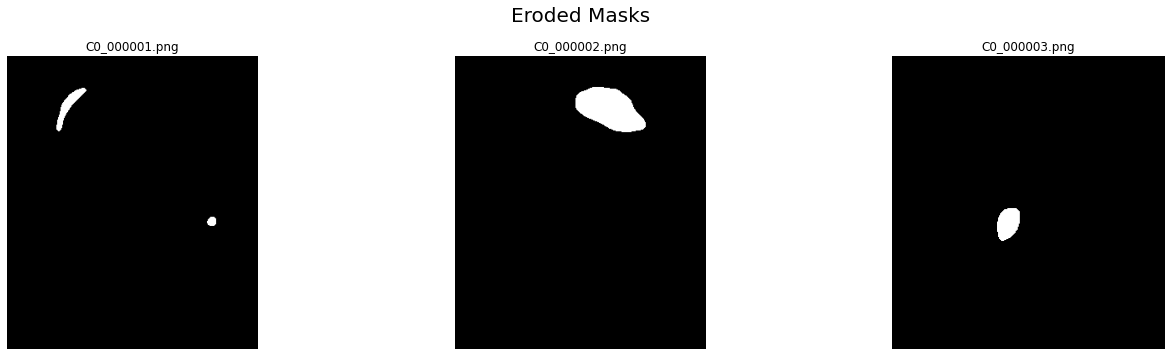

In [145]:
closing_edges = [cv2.medianBlur(img,7) for img in closing_edges]
plot_image_grid(closing_edges, 'Eroded Masks', nir_names)

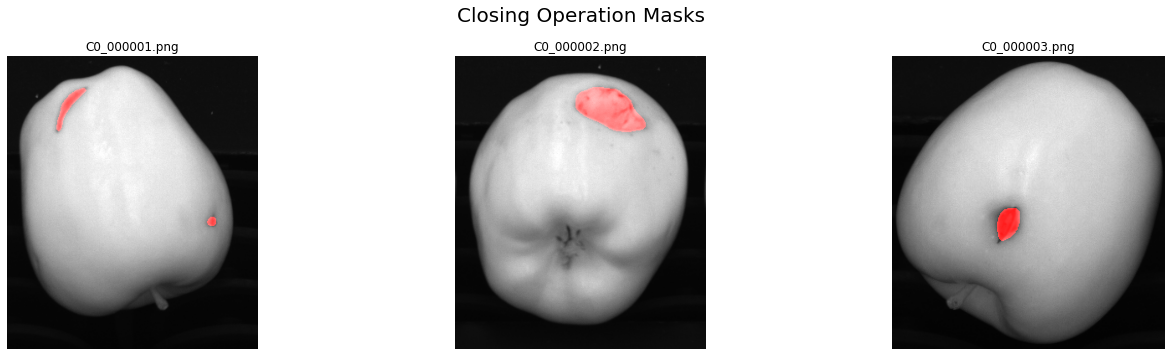

In [165]:
img_with_defects_area = []

for idx, img in enumerate(closing_edges):
    red_edge_mask = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    red_edge_mask[:,:,:-1] = 0
    
    img_with_defects_area.append(cv2.addWeighted(red_edge_mask, 1,  cv2.cvtColor(nir_imgs[idx], cv2.COLOR_GRAY2BGR), 1, 0))
    
    # img_with_defects_area.append(red_edge_mask  cv2.cvtColor(nir_imgs[idx], cv2.COLOR_GRAY2BGR))
    
plot_image_grid(img_with_defects_area, 'Closing Operation Masks', nir_names)